## Impact of denoising as one increases


In [1]:
#! lamin init --storage ./lamin-intro --schema bionty 

import scanpy as sc
from scprint import scPrint
from scdataloader import Preprocessor
from scdataloader.utils import load_genes
import numpy as np
import anndata as ad
from huggingface_hub import hf_hub_download

from scprint.tasks import Denoiser, withknn
from scprint.model.utils import downsample_profile
from scipy.stats import spearmanr
from anndata import AnnData
%load_ext autoreload
%autoreload 2

import torch
torch.set_float32_matmul_precision('medium')

→ connected lamindb: jkobject/scprint2


In [3]:
#model_checkpoint_file = hf_hub_download(
#    repo_id="jkobject/scPRINT", filename=f"v2-medium.ckpt"
#)
#model_checkpoint_file = ../data/
model_checkpoint_file = '../../../u9ld21ej.ckpt'

In [5]:
m = torch.load(model_checkpoint_file)


[autoreload of scdataloader.data failed: Traceback (most recent call last):
  File "/home/ml4ig1/miniconda3/envs/scprnt2/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/ml4ig1/miniconda3/envs/scprnt2/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 455, in superreload
    if not append_obj(module, old_objects, name, obj):
  File "/home/ml4ig1/miniconda3/envs/scprnt2/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 423, in append_obj
    in_module = hasattr(obj, "__module__") and obj.__module__ == module.__name__
  File "/home/ml4ig1/miniconda3/envs/scprnt2/lib/python3.10/site-packages/bionty/__init__.py", line 108, in __getattr__
    return globals()[name]
KeyError: '__module__'
]


In [17]:
rn = {'expr_encoder.encoder.1.weight': 'expr_encoder.encoder.2.weight',
      'expr_encoder.encoder.1.bias': 'expr_encoder.encoder.2.bias',
      'expr_encoder.encoder.5.weight': 'expr_encoder.encoder.6.weight',
      'expr_encoder.encoder.5.bias': 'expr_encoder.encoder.6.bias',
      'expr_decoder.fc.1.weight': 'expr_decoder.fc.2.weight',
      'expr_decoder.fc.1.bias': 'expr_decoder.fc.2.bias',
      "expr_decoder.fc.5.weight": "expr_decoder.fc.6.weight",
      "expr_decoder.fc.5.bias": "expr_decoder.fc.6.bias",
      }
m['state_dict'] = {rn[k] if k in rn else k: v for k, v in m['state_dict'].items()}

In [6]:
m['hyper_parameters']['label_decoders'] = {k:{u: str(w) for u,w in v.items()} for k,v in m['hyper_parameters']['label_decoders'].items()}

In [12]:
#rn = {'expr_encoder.encoder.1.weight': 'expr_encoder.encoder.2.weight',
#      'expr_encoder.encoder.1.bias': 'expr_encoder.encoder.2.bias',
#      'expr_encoder.encoder.5.weight': 'expr_encoder.encoder.6.weight',
#      'expr_encoder.encoder.5.bias': 'expr_encoder.encoder.6.bias',
#      'expr_decoder.fc.1.weight': 'expr_decoder.fc.2.weight',
#      'expr_decoder.fc.1.bias': 'expr_decoder.fc.2.bias',
#      "expr_decoder.fc.5.weight": "expr_decoder.fc.6.weight",
#      "expr_decoder.fc.5.bias": "expr_decoder.fc.6.bias",
#      }
#
#rn = {v:k for k,v in rn.items()}
#
#m['state_dict'] = {rn[k] if k in rn else k: v for k, v in m['state_dict'].items()}

In [7]:
#m['hyper_parameters']['organisms'] = ['NCBITaxon:10090', 'NCBITaxon:9606']
torch.save(m, model_checkpoint_file)

In [ ]:
m = torch.load(model_checkpoint_file)
if "prenorm" in m['hyper_parameters']:
    m['hyper_parameters'].pop("prenorm")
    torch.save(m, model_checkpoint_file)
if "label_counts" in m['hyper_parameters']:
    model = scPrint.load_from_checkpoint(model_checkpoint_file, precpt_gene_emb=None, classes=m['hyper_parameters']['label_counts'])
else:
    model = scPrint.load_from_checkpoint(model_checkpoint_file, precpt_gene_emb=None)

In [8]:
model = scPrint.load_from_checkpoint(model_checkpoint_file, precpt_gene_emb=None)

FYI: scPrint is not attached to a `Trainer`.


In [16]:
genes = load_genes(model.organisms)
set(model.genes) - set(genes.index)

/home/ml4ig1/Documents code/scDataLoader/scdataloader/utils.py:403: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


{'ENSG00000275313',
 'ENSG00000277796',
 'ENSG00000283886',
 'ENSG00000284156',
 'ENSG00000284947',
 'ENSG00000288396',
 'ENSG00000289722',
 'ENSMUSG00000078677',
 'ENSMUSG00000090592',
 'ENSMUSG00000094083',
 'ENSMUSG00000095076',
 'ENSMUSG00000095728',
 'ENSMUSG00000095742',
 'ENSMUSG00000110139',
 'ENSMUSG00000110291'}

In [24]:
#Get indices of genes that exist in genes. index
valid_indices = [i for i in range(len(model.genes)) if model.genes[i] in genes.index]
# Create-new •embedding-weights tensor with only valid genes new _weights -=-model.gene_encoder[01.embeddings.weight[valid_indices]
# Create- new-embedding layer with-correct size
new_embeddings = torch.nn.Embedding(len(valid_indices), model.gene_encoder[0].embeddings.embedding_dim, device=model.device)
#Copy the-weights-to-the new-embedding-layer new_embeddings.weight.data.= new_weights
#-Replace the old •embeddings with the new one
model.gene_encoder[0].embeddings = new_embeddings
model.genes = [i for i in model.genes if i in genes.index]

model = model.to(model.device)

# run denoising as depth increase

dataset | scprint | magic |
-|-|-|
retina | 33.6 | 29.5 |
kidney | ? | 37.5 |
glio_smart_highdepth | 30 | 20 |
lung_smart | 22.3 | 23.5 |

In [ ]:
LOC = '../..data/temp/' #

datasets = {
    "retina": "https://datasets.cellxgene.cziscience.com/53bd4177-79c6-40c8-b84d-ff300dcf1b5b.h5ad", #gNNpgpo6gATjuxTE7CCp
    "kidney": "https://datasets.cellxgene.cziscience.com/01bc7039-961f-4c24-b407-d535a2a7ba2c.h5ad",
    "glio_smart_highdepth": "https://datasets.cellxgene.cziscience.com/6ec440b4-542a-4022-ac01-56f812e25593.h5ad",
    "lung_smart": "https://datasets.cellxgene.cziscience.com/6ebba0e0-a159-406f-8095-451115673a2c.h5ad",
}

In [27]:
adata.obs['is_primary']= True


In [28]:
res = {}
for name, url in datasets.items():
    print("doing ", name)
    print("")
    adata = sc.read(LOC+name+".h5ad", backup_url=url)
    max_len = 4000 if adata.X.sum(1).mean() < 50_000 else 8000
    preprocessor = Preprocessor(
        force_preprocess=True,
        skip_validate=True,
        #drop_non_primary=False,
        do_postp=False
    )
    preprocessor = Preprocessor(do_postp=False)
    adata = preprocessor(adata)
    adata.layers['true'] = adata.X.copy()
    denoise = Denoiser(
        batch_size=40 if adata.X.sum(1).mean() < 50_000 else 20,
        max_len=max_len,
        max_cells=30_000,
        doplot=False,
        num_workers=8,
        predict_depth_mult=5,
        downsample_expr=0.7,
    )
    res['scprint_'+name], idx, nadata = denoise(model, adata)
    print(res['scprint_'+name])
    
    # doing magic
    subadata = adata[idx, adata.var.index.isin(model.genes) & adata.var.highly_variable].copy() if idx is not None else adata[:, adata.var.index.isin(model.genes) & adata.var.highly_variable].copy()
    subadata.X = downsample_profile(torch.Tensor(subadata.X.toarray()), 0.7)
    denoised_adata = sc.external.pp.magic(subadata.copy(), copy=True, n_jobs=10, solver='approximate', verbose=True)

    reco = denoised_adata.X
    true = subadata.layers['true'].toarray()
    noisy = subadata.X
    corr_coef, p_value = spearmanr(
        np.vstack(
            [reco[true != 0], noisy[true != 0], true[true != 0]]).T
    )
    res['magic_'+name] = {
        "reco2noisy": corr_coef[0, 1],
        "reco2full": corr_coef[0, 2],
        "noisy2full": corr_coef[1, 2],
    }
    print(res['magic_'+name])
    print("--------------------------------")
    print("")


doing  retina

Dropping layers:  KeysView(Layers with keys: )
checking raw counts
removed 0 non primary cells, 51645 renamining
filtered out 24 cells, 51621 renamining
Removed 18 genes not known to the ontology
Removed 0 duplicate genes
Added 34343 genes in the ontology but not present in the dataset
validating


/home/ml4ig1/Documents code/scDataLoader/scdataloader/preprocess.py:281: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  adata.uns["unseen_genes"] = list(unseen)


starting QC
Seeing 24853 outliers (48.14% of total dataset):
done
AnnData object with n_obs × n_vars = 51621 × 70704
    obs: 'biosample_id', 'donor_id', 'cell_type_ontology_term_id', 'organism_ontology_term_id', 'disease_ontology_term_id', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'cell_type__custom', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'is_primary_data', 'age', 'self_reported_ethnicity_ontology_term_id', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'nnz', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'feature_is_filtered', 'feature

/home/ml4ig1/Documents code/scDataLoader/scdataloader/utils.py:372: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  


> /home/ml4ig1/Documents code/scPRINT/scprint/tasks/denoise.py(138)__call__()
    136 
    137         pdb.set_trace()
--> 138         with torch.no_grad(), torch.autocast(device_type=device, dtype=self.dtype):
    139             for batch in tqdm(dataloader):
    140                 gene_pos, expression, depth = (

> /home/ml4ig1/Documents code/scPRINT/scprint/tasks/denoise.py(139)__call__()
    137         pdb.set_trace()
    138         with torch.no_grad(), torch.autocast(device_type=device, dtype=self.dtype):
--> 139             for batch in tqdm(dataloader):
    140                 gene_pos, expression, depth = (
    141                     batch["genes"].to(device),



  0%|          | 0/750 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f38ab838700>AssertionError
Exception ignored in: Traceback (most recent call last):
  File "/home/ml4ig1/miniconda3/envs/scprnt2/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f38ab838700>    
self._shutdown_workers()Traceback (most recent call last):

  File "/home/ml4ig1/miniconda3/envs/scprnt2/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
  File "/home/ml4ig1/miniconda3/envs/scprnt2/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
        if w.is_alive():
self._shutdown_workers()  File "/home/ml4ig1/miniconda3/envs/scprnt2/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

    Exception ignored in:   File "/home/ml4ig1/miniconda3/envs/scprnt2/lib/python3.10/site-packages/torch/util

> /home/ml4ig1/Documents code/scPRINT/scprint/tasks/denoise.py(141)__call__()
    139             for batch in tqdm(dataloader):
    140                 gene_pos, expression, depth = (
--> 141                     batch["genes"].to(device),
    142                     batch["x"].to(device),
    143                     batch["depth"].to(device),

> /home/ml4ig1/Documents code/scPRINT/scprint/tasks/denoise.py(142)__call__()
    140                 gene_pos, expression, depth = (
    141                     batch["genes"].to(device),
--> 142                     batch["x"].to(device),
    143                     batch["depth"].to(device),
    144                 )

> /home/ml4ig1/Documents code/scPRINT/scprint/tasks/denoise.py(143)__call__()
    141                     batch["genes"].to(device),
    142                     batch["x"].to(device),
--> 143                     batch["depth"].to(device),
    144                 )
    145                 if self.downsample_expr is not None:

> /h

100%|██████████| 750/750 [03:56<00:00,  3.18it/s]


AnnData object with n_obs × n_vars = 30000 × 44741
    obs: 'pred_cell_type_ontology_term_id', 'pred_tissue_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_tissue_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
    obsm: 'scprint_emb'
    layers: 'scprint_mu', 'scprint_theta', 'scprint_pi'
{'reco2noisy': 0.05623899675635993, 'reco2full': 0.10804752103711349, 'noisy2full': 0.3719765143759479}
Calculating MAGIC...
  Running MAGIC on 30000 cells and 2557 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 3.59 seconds.
    Calculating KNN search...
    Calculated KNN search in 38.51 seconds.
    Calculating affinities...
    Calculated affinities in 39.

/home/ml4ig1/Documents code/scDataLoader/scdataloader/preprocess.py:281: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  adata, organism=adata.obs.organism_ontology_term_id[0], need_all=False


starting QC
Seeing 404 outliers (2.00% of total dataset):
done
AnnData object with n_obs × n_vars = 20215 × 70704
    obs: 'donor_id', 'self_reported_ethnicity_ontology_term_id', 'organism_ontology_term_id', 'sample_uuid', 'sample_preservation_method', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'suspension_uuid', 'suspension_type', 'library_uuid', 'assay_ontology_term_id', 'mapped_reference_annotation', 'is_primary_data', 'cell_type_ontology_term_id', 'author_cell_type', 'disease_ontology_term_id', 'reported_diseases', 'sex_ontology_term_id', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.rpl', 'percent.rps', 'doublet_id', 'nCount_SCT', 'nFeature_SCT', 'seurat_clusters', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'nnz', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_coun

/home/ml4ig1/Documents code/scDataLoader/scdataloader/utils.py:372: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


> /home/ml4ig1/Documents code/scPRINT/scprint/tasks/denoise.py(138)__call__()
    136 
    137         pdb.set_trace()
--> 138         with torch.no_grad(), torch.autocast(device_type=device, dtype=self.dtype):
    139             for batch in tqdm(dataloader):
    140                 gene_pos, expression, depth = (



100%|██████████| 506/506 [02:27<00:00,  3.42it/s]


AnnData object with n_obs × n_vars = 20215 × 44741
    obs: 'pred_cell_type_ontology_term_id', 'pred_tissue_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_tissue_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
    obsm: 'scprint_emb'
    layers: 'scprint_mu', 'scprint_theta', 'scprint_pi'
{'reco2noisy': 0.052875518389119004, 'reco2full': 0.10221658644233761, 'noisy2full': 0.35531540221910196}
Calculating MAGIC...
  Running MAGIC on 20215 cells and 2703 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 3.71 seconds.
    Calculating KNN search...
    Calculated KNN search in 16.96 seconds.
    Calculating affinities...
    Calculated affinities in 1

/home/ml4ig1/Documents code/scDataLoader/scdataloader/preprocess.py:281: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  adata, organism=adata.obs.organism_ontology_term_id[0], need_all=False


starting QC
Seeing 71 outliers (1.99% of total dataset):
done
AnnData object with n_obs × n_vars = 3567 × 70704
    obs: 'Sample.type', 'Selection', 'Location', 'Sample.name', 'Total_reads', 'Unique_reads', 'Unique_reads_percent', 'Splice_sites_total', 'Splice_sites_Annotated', 'Splice_sites_GT.AG', 'Splice_sites_GC.AG', 'Splice_sites_AT.AC', 'Splice_sites_non_canonical', 'Multimapping_reads_percent', 'Unmapped_mismatch', 'Unmapped_short', 'Unmapped_other', 'ERCC_reads', 'Non_ERCC_reads', 'ERCC_to_non_ERCC', 'Genes_detected', 'housekeeping_cluster', 'Cluster_2d', 'Cluster_2d_color', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'donor_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'developme

: 

In [9]:
adata = sc.read(LOC+"lung_smart"+".h5ad")

In [10]:
max_len = 4000 if adata.X.sum(1).mean() < 50_000 else 8000
preprocessor = Preprocessor(
    force_preprocess=True,
    skip_validate=True,
    drop_non_primary=False,
    do_postp=False
)
preprocessor = Preprocessor(do_postp=False)
adata = preprocessor(adata)
adata.layers['true'] = adata.X.copy()
denoise = Denoiser(
    batch_size=40 if adata.X.sum(1).mean() < 50_000 else 20,
    max_len=max_len,
    max_cells=30_000,
    doplot=False,
    num_workers=8,
    predict_depth_mult=5,
    downsample_expr=0.7,
)

Dropping layers:  KeysView(Layers with keys: )
checking raw counts
removed 0 non primary cells, 9409 renamining
filtered out 0 cells, 9409 renamining
Removed 39 genes not known to the ontology
Removed 0 duplicate genes
Added 16328 genes in the ontology but not present in the dataset
validating


/home/ml4ig1/Documents code/scDataLoader/scdataloader/preprocess.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  adata, organism=adata.obs.organism_ontology_term_id[0], need_all=False


starting QC
Seeing 5471 outliers (58.14% of total dataset):
done
AnnData object with n_obs × n_vars = 9409 × 70704
    obs: 'nGene', 'nReads', 'plate.barcode', 'cell.id', 'region', 'label', 'sorter', 'sort.location', 'sample', 'location', 'donor_id', 'percent.ercc', 'percent.ribo', 'gating', 'free_annotation', 'Number of splices: Total', 'Number of splices: Annotated (sjdb)', 'Number of splices: GT-AG', 'Number of splices: GC-AG', 'Number of splices: AT-AC', 'Number of splices: Non-canonical', 'Mapping speed, Million of reads per hour', 'Average input read length', 'compartment', 'tissue_ontology_term_id', 'disease_ontology_term_id', 'development_stage_ontology_term_id', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'obs

In [11]:
_, idx, nadata = denoise(model, adata)

working on 2435 accepted genes


/home/ml4ig1/Documents code/scDataLoader/scdataloader/utils.py:403: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


not on wandb, could not set name


100%|██████████| 471/471 [00:37<00:00, 12.52it/s]


logging the anndata
AnnData object with n_obs × n_vars = 9409 × 44741
    obs: 'pred_cell_type_ontology_term_id', 'pred_tissue_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_tissue_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
    obsm: 'scprint_emb'
    layers: 'scprint_mu', 'scprint_theta', 'scprint_pi'


In [12]:
nadata = nadata[: ,nadata.var.index.isin(adata.var.index)]
adata = adata[:, adata.var.index.isin(nadata.var.index)]

In [13]:
# Get min and max from adata
adata_min = np.array([1]*adata.X.shape[0])
adata_max = adata.X.max(1).data

# Get min and max for each row in nadata
nadata_min = nadata.layers['scprint_mu'].data.reshape(adata.X.shape[0],-1).min(axis=1)
nadata_max = nadata.layers['scprint_mu'].data.reshape(adata.X.shape[0],-1).max(axis=1)

# Rescale each row to match adata range
# Reshape the min/max arrays to match the matrix dimensions for broadcasting
nadata_min = nadata_min.reshape(-1, 1)
nadata_max = nadata_max.reshape(-1, 1)
adata_min = adata_min.reshape(-1, 1)
adata_max = adata_max.reshape(-1, 1)

# Perform the rescaling with properly shaped arrays
nadata.layers['scprint_mu'].data = ((nadata.layers['scprint_mu'].data.reshape(adata.X.shape[0],-1) - nadata_min) / (nadata_max - nadata_min) * (adata_max - adata_min) + adata_min).flatten()


In [14]:
# Create a mask for where scprint_mu is 0
zero_mask = nadata.layers['scprint_mu'] == 0

# Replace zeros with corresponding values from adata.X
nadata.layers['scprint_mu'][zero_mask] = adata.X[zero_mask]


/home/ml4ig1/miniconda3/envs/scprnt2/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3579: SparseEfficiencyWarning: Comparing a sparse matrix with 0 using == is inefficient, try using != instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ml4ig1/miniconda3/envs/scprnt2/lib/python3.10/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [18]:
adata.obs.cell_type

88ebe820-e6fe-497c-a83d-0f503b648552      endothelial cell
f9bed62e-7ffd-4e11-b289-4420c40d657c      endothelial cell
d85673cd-02ac-4749-98d4-fcf21f3f4d75      endothelial cell
ea4905f7-0aed-4e65-bf56-074c1599ab4a      endothelial cell
1a9b3245-3a57-48bc-8ce9-8d94a613f4e5      endothelial cell
                                               ...        
e026b196-4dae-4382-a70d-07135dbf6ff8    lung ciliated cell
aa04edef-395b-478b-b864-154063a869e6    lung ciliated cell
452e3f23-adaf-49c1-96ac-de6e0ceeb0a2    lung ciliated cell
9ec73226-e3a5-48fb-92d0-9d76518363c5    lung ciliated cell
b06bd778-60bb-45b3-bc8b-fea212e687f8    lung ciliated cell
Name: cell_type, Length: 9409, dtype: category
Categories (40, object): ['fibroblast', 'epithelial cell', 'endothelial cell', 'club cell', ..., 'lung goblet cell', 'lung neuroendocrine cell', 'lung ciliated cell', 'endothelial cell of artery']

In [19]:
# Create UMAP visualization of scprint_mu layer
import scanpy as sc

# Compute UMAP
# Compute PCA first
sc.pp.pca(nadata, layer='scprint_mu')

sc.pp.neighbors(nadata, use_rep='X_pca', )
sc.tl.umap(nadata, )

# Plot UMAP colored by cell type
sc.pl.umap(nadata, color=adata.obs.cell_type.tolist(), title='UMAP of scPRINT denoised data', 
           frameon=False, legend_loc='on data', legend_fontsize=8)


KeyboardInterrupt: 

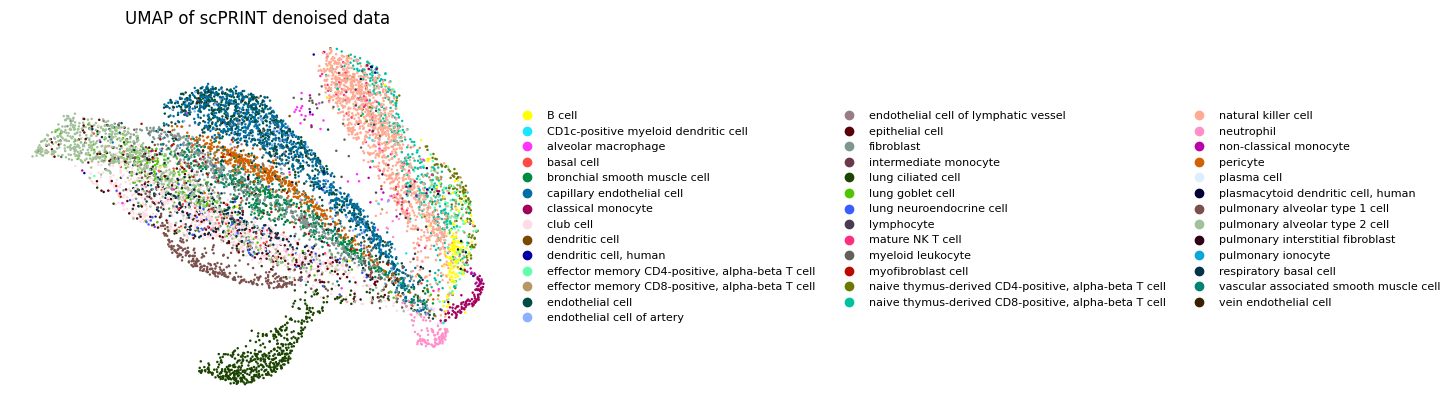

In [43]:
sc.pl.umap(nadata, color="cell_type", title='UMAP of scPRINT denoised data', 
           frameon=False, legend_fontsize=8)

In [69]:
adata.X = downsample_profile(torch.Tensor(adata.X.toarray()), 0.7).numpy()

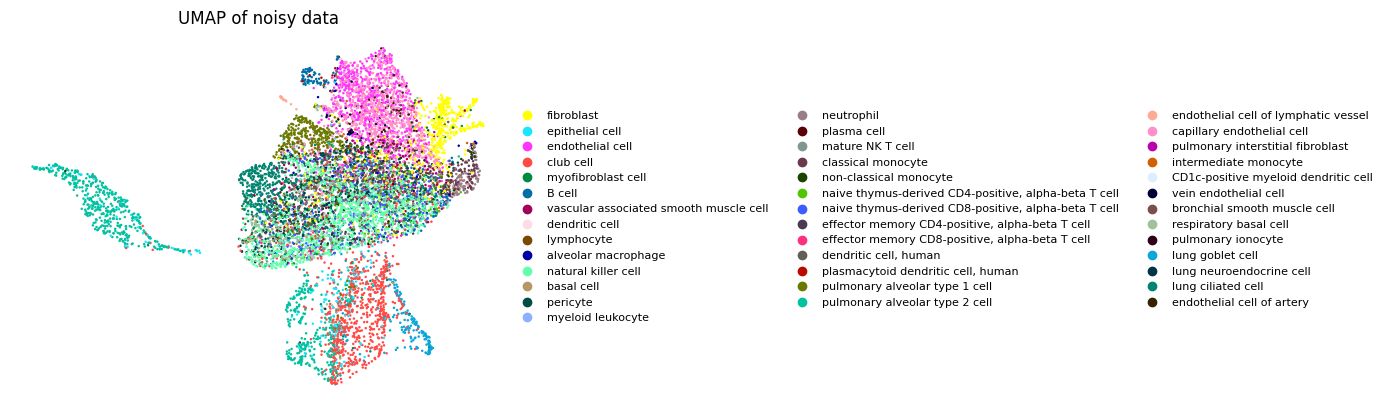

In [70]:
sc.pp.pca(adata)
sc.pp.neighbors(adata, use_rep='X_pca')
sc.tl.umap(adata)

# Plot UMAP colored by cell type
sc.pl.umap(adata, color="cell_type", title='UMAP of noisy data', 
           frameon=False, legend_fontsize=8, palette=nadata.uns['cell_type_colors'])

In [53]:
adata

AnnData object with n_obs × n_vars = 9409 × 23142
    obs: 'nGene', 'nReads', 'plate.barcode', 'cell.id', 'region', 'label', 'sorter', 'sort.location', 'sample', 'location', 'donor_id', 'percent.ercc', 'percent.ribo', 'gating', 'free_annotation', 'Number of splices: Total', 'Number of splices: Annotated (sjdb)', 'Number of splices: GT-AG', 'Number of splices: GC-AG', 'Number of splices: AT-AC', 'Number of splices: Non-canonical', 'Mapping speed, Million of reads per hour', 'Average input read length', 'compartment', 'tissue_ontology_term_id', 'disease_ontology_term_id', 'development_stage_ontology_term_id', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'nnz', 'n_genes', 'n_genes_by_counts', 'log1p_n

In [57]:
adata.layers['true'].sum(1).mean(), adata.X.sum(1).mean()

(979721.4, 979721.4)

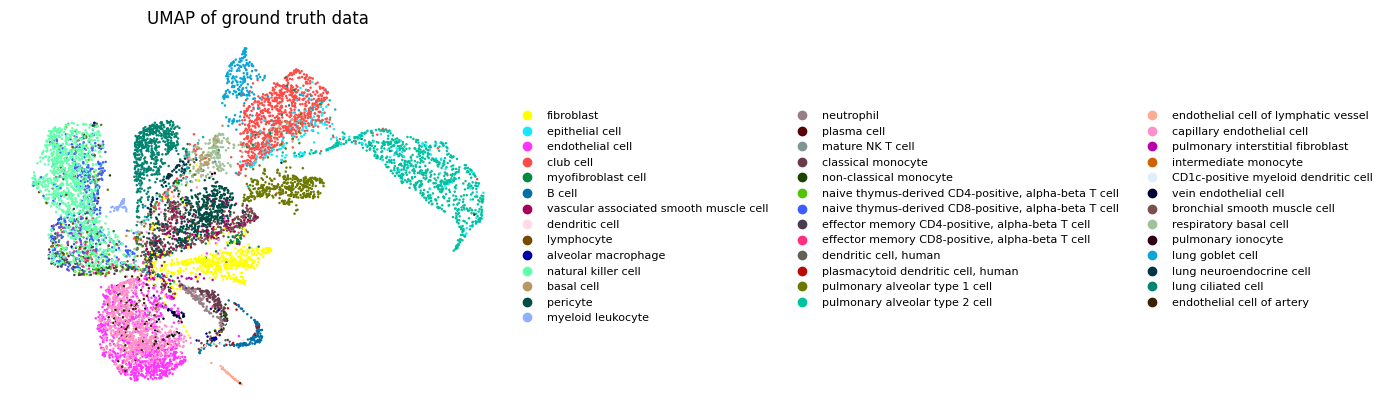

In [54]:
adata.obsm['X_pca'] = sc.pp.pca(adata.layers['true'])
sc.pp.neighbors(adata, use_rep='X_pca')
sc.tl.umap(adata)

# Plot UMAP colored by cell type
sc.pl.umap(adata, color="cell_type", title='UMAP of ground truth data', 
           frameon=False, legend_fontsize=8, palette=nadata.uns['cell_type_colors'])

In [ ]:
scprint vs magic (full vs rare)
33.6 vs 37.7 - 28.2 vs 26.4
30 vs 20 - 28.5 vs 17.5
22.3 vs 23.5 - 23.4 vs 5.0

## with MAGIC rare cells

In [134]:
ct = "pericyte"
subadata.obs.cell_type.value_counts()
#microglial cell, microfold cell of epithelium of small intestine, mesangial cell, pericyte

cell_type
pigmented ciliary epithelial cell        13383
non-pigmented ciliary epithelial cell     4687
ciliary muscle cell                       3776
fibroblast                                3271
Schwann cell                              1778
macrophage                                1473
melanocyte                                1169
lymphocyte                                 222
blood vessel endothelial cell              149
pericyte                                    92
Name: count, dtype: int64

In [135]:
reco = denoised_adata[subadata.obs.cell_type==ct].X
true = subadata[subadata.obs.cell_type==ct].layers['true'].toarray()
noisy = subadata[subadata.obs.cell_type==ct].X
corr_coef, p_value = spearmanr(
    np.vstack(
        [reco[true != 0], noisy[true != 0], true[true != 0]]).T
)
{
    "reco2noisy": corr_coef[0, 1],
    "reco2full": corr_coef[0, 2],
    "noisy2full": corr_coef[1, 2],
}

{'reco2noisy': 0.14750170131134832,
 'reco2full': 0.38880325415511774,
 'noisy2full': 0.3443993707013129}

## scPRINT rare cells

In [136]:
denoise = Denoiser(
    batch_size=40,
    max_len=5000,
    max_cells=200,
    doplot=False,
    predict_depth_mult=6,
    downsample = 0.7,
    how="most var"
)
metrics, idx, genes, expr = denoise(model, adata[adata.obs.cell_type==ct])
metrics

/home/ml4ig1/miniconda3/envs/scprnt2/lib/python3.10/site-packages/scdataloader/utils.py:400: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)
100%|██████████| 3/3 [00:01<00:00,  1.88it/s]


{'reco2noisy': 0.3439042832146162,
 'reco2full': 0.5496913631860156,
 'noisy2full': 0.31487289773608945}